# Merian Part 2: images and Sersic fitting

**Prerequisites**
- Need to install `photutils` and `statmorph`
- Finished the Photometric Redshift notebook and Merian Part 1 notebook

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.linewidth'] = 2

In [2]:
required_packages = ['statmorph', 'photutils']  # Define the required packages for this notebook

import sys
import subprocess

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Download utils.py
    !wget -q -O /content/utils.py https://raw.githubusercontent.com/AstroJacobLi/ObsAstGreene/refs/heads/main/book/docs/utils.py
    # Function to check and install missing packages
    def install_packages(packages):
        for package in packages:
            try:
                __import__(package)
            except ImportError:
                print(f"Installing {package}...")
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
    # Install any missing packages
    install_packages(required_packages)
else:
    # If not in Colab, adjust the path for local development
    sys.path.append('/Users/jiaxuanl/Dropbox/Courses/ObsAstGreene/book/docs/')

# Get the directory right
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  os.chdir('/content/drive/Shareddrives/AST207/data')
else:
    os.chdir('../../../_static/ObsAstroData/')

In [3]:
from utils import pad_psf, show_image

## 1: Enjoy Merian images!

We've been playing with catalogs so far. But the Merian images are truly amazing! In this part, let's take a look at those images and try to make a color-composite image by combining the Hyper Suprime-Cam (HSC) data with Merian. 

The Merian (and the corresponding HSC) images for objects in the Merian redshift range are made available in class's google drive. 

In [34]:
cat_inband = Table.read('./merian/cosmos_Merian_DR1_specz_inband.fits')
print('Total number of galaxies:', len(cat_inband))

Total number of galaxies: 161


In [35]:
cutout_dir = "./merian/cutouts/"

In [115]:
from astropy.io import fits
i = 10
obj = cat_inband[i]
coord = SkyCoord(obj['coord_ra_Merian'], obj['coord_dec_Merian'], unit='deg')
name = obj['name']
print('Name:', name)

# Open images and psfs
cutouts = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}.fits"))[1].data for band in ['g', 'r', 'i', 'z']}
cutouts['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merim.fits"))[1].data

Name: J095828.56+013901.69


We use the function `show_image` to display the data:

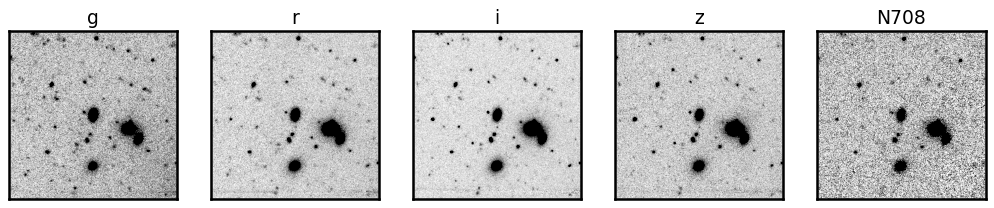

In [72]:
percl = 98 # this changes the contrast and dynamic range of the display

fig, axes = plt.subplots(1, 5, figsize=(14, 3))
for i, band in enumerate(cutouts.keys()):
    show_image(cutouts[band], fig=fig, ax=axes[i], cmap='Greys', percl=percl)
    axes[i].set_title(band, fontsize=15)

**Exercise 1**

Change the `percl` parameter from 92 to 99.9, and comment on how that changes the look of the galaxy. If you are interested in the low-surface-brightness features, should you tune `percl` low or high?

In [73]:
## your answer

Black & White images are cool but a bit boring... Let's make them colorful! Here we use the method in [Lupton et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract), featuring our own [Robert Lupton](https://web.astro.princeton.edu/people/robert-lupton)! 

Text(0, 1.02, 'g')

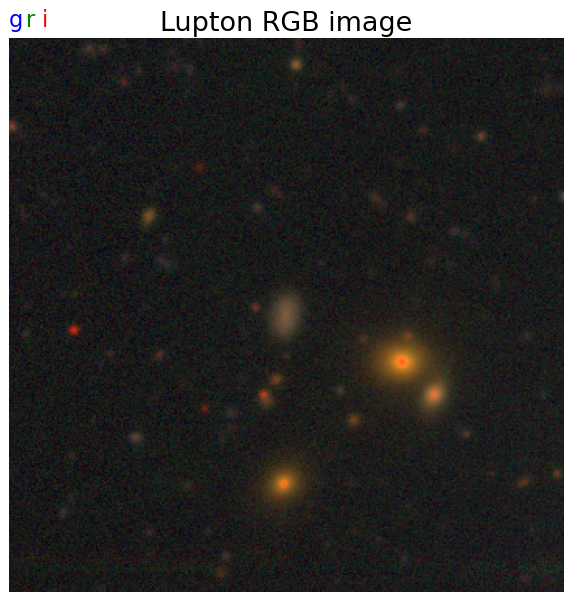

In [74]:
from astropy.visualization import make_lupton_rgb
rgb = make_lupton_rgb(cutouts['i'], cutouts['r'], cutouts['g'], stretch=1, Q=10, minimum=-0.1)
plt.figure(figsize=(8, 8))
plt.imshow(rgb, origin='lower')
plt.axis('off')

ax = plt.gca()
plt.title('Lupton RGB image')
plt.text(0.06, 1.02, 'i', transform=ax.transAxes, color='red')
plt.text(0.03, 1.02, 'r', transform=ax.transAxes, color='green')
plt.text(0, 1.02, 'g', transform=ax.transAxes, color='blue')

**Exercise 2**

There are three parameters in the `lupton_rgb` function: `stretch`, `Q`, and `minimum`. Try to play with these parameters, and find a combination that makes the most beautiful color image. 

In [75]:
## your answer

## 2: Sersic fitting

A galaxy's light distribution is often described by a [Sersic](https://en.wikipedia.org/wiki/S%C3%A9rsic_profile) model. For a comprehensive introduction to the Sersic model, see [this paper](https://arxiv.org/abs/astro-ph/0503176). Here let's try to fit a Sersic model to the Merian galaxies. 

**Note**: For HSC and Merian images below, the zeropoint is always 27.0 mag, and the pixel scale is away 0.168 arcsec/pixel.

In [93]:
import statmorph
from photutils.segmentation import detect_threshold, detect_sources
from astropy.convolution import convolve_fft
from utils import get_img_central_region
from astropy.io import fits

In [77]:
# Open images and psfs
cutouts = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}.fits"))[1].data for band in ['g', 'r', 'i', 'z']}
cutouts['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merim.fits"))[1].data

cutout_headers = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}.fits"))[1].header for band in ['g', 'r', 'i', 'z']}
cutout_headers['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merim.fits"))[1].header

psfs = {band: fits.open(os.path.join(cutout_dir, "hsc", f"{name}_HSC-{band}_psf.fits"))[0].data for band in ['g', 'r', 'i', 'z']}
psfs['N708'] = fits.open(os.path.join(cutout_dir, "merian", f"{name}_N708_merpsf.fits"))[0].data

In [112]:
# We only include the central region (150 x 150 pix) of the bigger image
# This makes the fitting faster
band = 'i'
imgs = get_img_central_region(cutouts, 150)
img = imgs[band]
psf = psfs[band]

We first need to detect the "footprint" of the galaxy that we are intersted. We use `detect_sources` function in `photutils.segmentation` to extract sources that are $1.5\sigma$ above the noise level. The `detect_threshold` function roughly estimates the background noise level. 

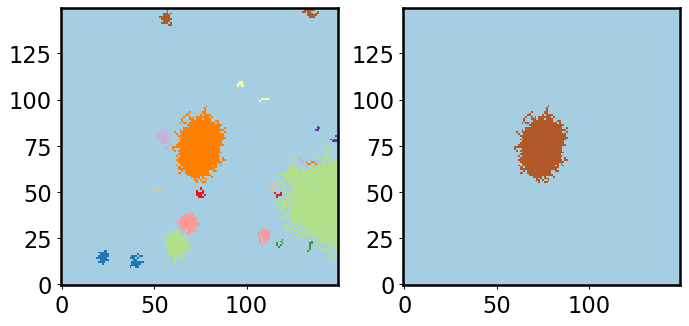

In [100]:
threshold = detect_threshold(img, 1.5)
npixels = 5  # minimum number of connected pixels
segmap = detect_sources(img, threshold, npixels)
obj_mask = ~segmap.data_ma.mask

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(segmap, origin='lower', cmap='Paired', interpolation='none')

ind = segmap.data[img.shape[1]//2, img.shape[0]//2]
segmap.keep_label(ind)

ax2.imshow(segmap, origin='lower', cmap='Paired', interpolation='none')

In the left panel, we show the "segmentation map" for all sources above $1.5\sigma$. Many sources are detected. However, we only want the central one, so we use `segmap.keep_label(ind)`. The right panel shows the segmentation map after this step. This segmentation map will be used in the Sersic fitting.

Sersic fitting needs the background noise level to calculate the chi-square. Let's use `photutils.background.Backgroud2D` to estimate the background noise. In this step, we will provide an object mask `obj_mask` such that the light from astrophysical sources will not bias the background estimation. `obj_mask` was constructed when we first extracted the segmentation map: `obj_mask = ~segmap.data_ma.mask`. In this mask, `True` means that the pixel belongs to a real source and should be masked; `False` means that it should not be masked. 

In [101]:
from photutils.background import Background2D
bkg = Background2D(img, 32, mask=obj_mask)

This `bkg` object contains many information about the background, including the rms of the background level. This is exactly what we need.

In [102]:
bkg.background_rms

array([[0.04678689, 0.04678655, 0.04678586, ..., 0.04762321, 0.0476259 ,
        0.04762836],
       [0.04678664, 0.0467863 , 0.04678561, ..., 0.04762315, 0.04762583,
        0.04762829],
       [0.04678614, 0.0467858 , 0.04678512, ..., 0.04762302, 0.0476257 ,
        0.04762815],
       ...,
       [0.04861095, 0.04861053, 0.0486097 , ..., 0.04812019, 0.04812055,
        0.04812087],
       [0.0486109 , 0.04861048, 0.04860964, ..., 0.04812046, 0.04812081,
        0.04812114],
       [0.04861085, 0.04861043, 0.04860959, ..., 0.04812071, 0.04812106,
        0.04812138]])

Now it's time to do Sersic fitting! We use a package called `statmorph`. It also provides many other measurements. See [its documentation](https://statmorph.readthedocs.io/en/latest/) for details.

In [103]:
source_morphs = statmorph.source_morphology(
    img, segmap, weightmap=bkg.background_rms, psf=psf)
morph = source_morphs[0]

That's it! Let's visualize the results:

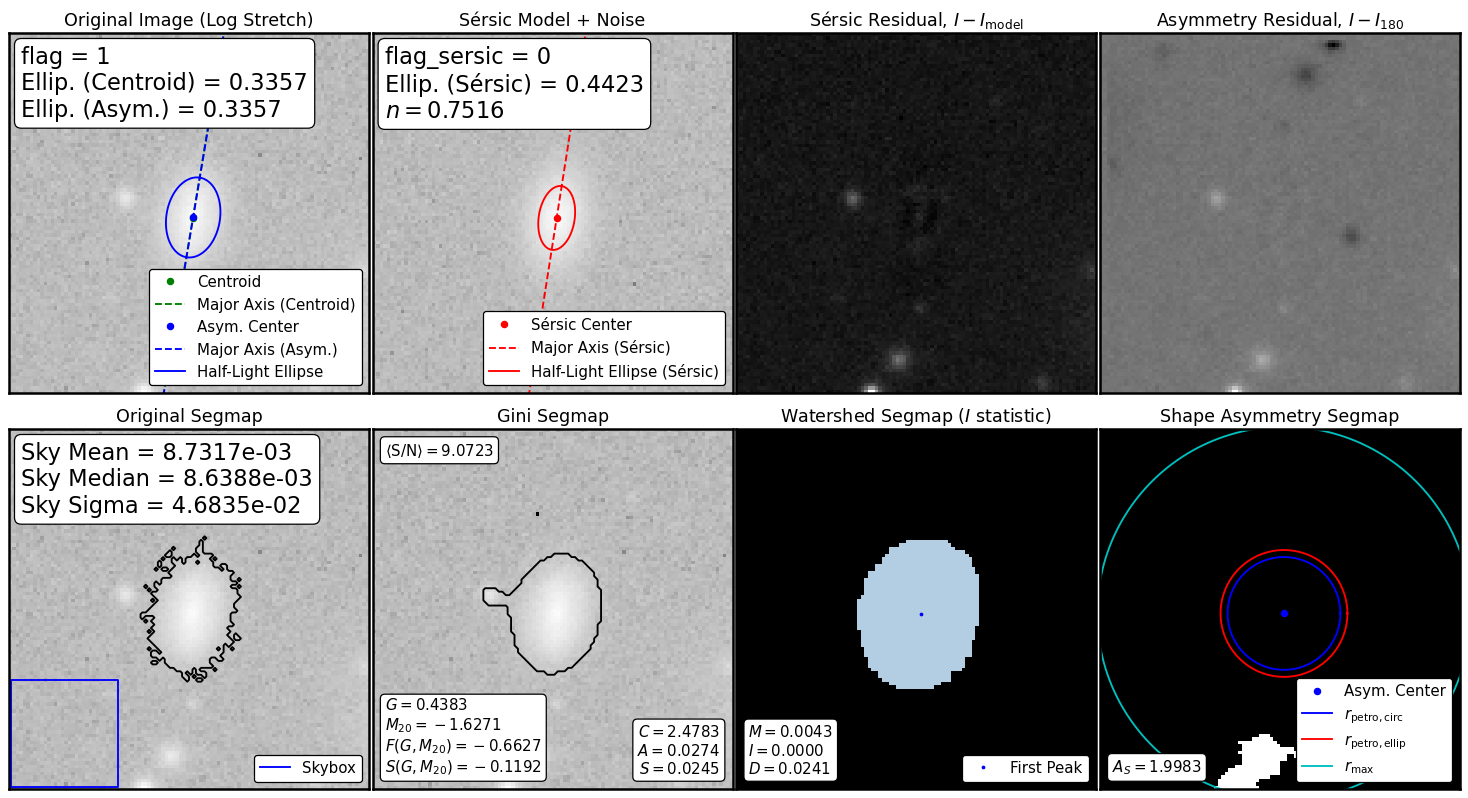

In [104]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

We see lots of information on this plot! For Sersic fitting, we should only focus on the first three panels. The first panel shows the original image, the second shows the best-fit Sersic model, and the third shows the residual. Overall, the fit is pretty good (also indicated by `flag_sersic = 0`)! The residual for this galaxy is very smooth. However, for other galaxies, there will be some structures not captured by the Sersic model. Sersic model is not perfect, but it's useful. It gives you a rough idea of the size and luminosity of the galaxy.

Let's check the best-fit parameters, such as the half-light radius, ellipticity, etc. 
In this way, we can measure the properties of many more galaxies.

In [105]:
print('Half light radius:', morph.sersic_rhalf)
print('Ellipticity:', morph.sersic_ellip)
print('Sersic index:', morph.sersic_n)
print('Sersic amplitude:', morph.sersic_amplitude)

Half light radius: 9.315653811816333
Ellipticity: 0.44231088259076656
Sersic index: 0.7515958101899337
Sersic amplitude: 0.6895891711804388


You can use the following function to calculate the total magnitude of the best-fit Sersic model.

In [111]:
def calc_mtot(morph, zpt=27.0, pixscale=0.168):
    # based on https://arxiv.org/abs/astro-ph/0503176
    from scipy.special import gammaincinv, gamma
    b_n = gammaincinv(2. * morph.sersic_n, 0.5)
    f_n = gamma(2*morph.sersic_n)*morph.sersic_n*np.exp(b_n)/b_n**(2*morph.sersic_n)
    mu_e = zpt - 2.5*np.log10(morph.sersic_amplitude/pixscale**2)
    mu_e_ave = mu_e - 2.5*np.log10(f_n)
    r_circ = morph.sersic_rhalf * np.sqrt(1 - morph.sersic_ellip)
    A_eff = np.pi*(r_circ * pixscale)**2
    m_tot = mu_e_ave - 2.5*np.log10(2*A_eff)
    return m_tot

In [114]:
print(f'Total magnitude in the {band} band:', calc_mtot(morph))

Total magnitude in the i band: 20.627837847524347


**Exercise 3**

1. Repeat this Sersic fitting for a few other galaxies, and make sure it works for most of them. Also try it in other bands, such as `N708`.

2. When extracting the segmentation map, let's try to smooth the image a bit so small-scale noise peaks can be smeared out. We can do this by convolving the image with the PSF. Note that this is only important for detection; we won't use this convolved image for Sersic fitting. You can use `from astropy.convolution import convolve`, and use the PSF from above. Then, use the convolved image in the `detect_sources()` function.

**Exercise 4**

1. For this galaxy `refID=10` and `Name: J095828.56+013901.69`, write a function to calculate its physical half-light size using the half-light radius from Sersic fit and its spec-z. You can use `astropy.cosmology` to calculate the angular diameter distance at a given distance. Express the physical size of this galaxy in `kpc`. 

2. For all galaxies in our sample, do Sersic fitting, then extract their physical sizes. Make a scatter plot for their sizes and stellar masses. 